In [2]:
%cd ..

c:\Users\esper\Desktop\injury_forecasting


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.aggregation import (
    aggregate_panel,
    check_panel_balance
)

from src.config import (
    DATA_DIR,
    RESULTS_DIR,
    FIGURES_DIR
)

from src.plotting import (
    set_plot_style
)

set_plot_style()

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv(
    DATA_DIR / "processed" / "federal_df.csv", 
    parse_dates=['EventDate'], 
    low_memory=False)

df.shape

(96393, 27)

In [7]:
weekly_panel = aggregate_panel(
    df,
    date_col='EventDate',
    group_col='State',
    target_cols=("Hospitalized",),
    freq="W-MON",
    agg='sum',
    complete_panel=True
)

weekly_panel.head(), weekly_panel.shape

(     State       Date  Hospitalized
 0  ALABAMA 2015-01-05           0.0
 1  ALABAMA 2015-01-12           2.0
 2  ALABAMA 2015-01-19           4.0
 3  ALABAMA 2015-01-26           6.0
 4  ALABAMA 2015-02-02           3.0,
 (15930, 3))

In [9]:
from src.features import build_panel_features

In [10]:
X_wk, y_wk, meta_wk = build_panel_features(
    panel_df=weekly_panel,
    target="Hospitalized",
    group_col="State",
    date_col="Date",
    freq="W-MON",
    add_calendar=True,
    add_lags=True,
    add_rolling=True,
    add_ewm=True,
    lags=(1, 2, 4, 8, 12, 24, 52),
    rolling_windows=(12, 24, 52),
    ewm_spans=(12, 24, 52),
    dropna=True,
)





In [11]:
import pandas as pd
import numpy as np

def yearly_train_ends(meta: pd.DataFrame, date_col: str = "Date") -> list[pd.Timestamp]:
    dates = pd.to_datetime(meta[date_col], errors="raise")
    tmp = pd.DataFrame({"Date": dates})
    tmp["year"] = tmp["Date"].dt.year
    ends = tmp.groupby("year")["Date"].max().sort_values()
    return list(ends.values)

def rolling_origin_masks(
    meta: pd.DataFrame,
    date_col: str,
    train_ends: list[pd.Timestamp],
    test_size: int = 52,
) -> list[dict]:
    dates = pd.to_datetime(meta[date_col], errors="raise")
    unique_dates = pd.Index(np.sort(dates.unique()))

    splits = []
    for te in train_ends:
        te = pd.to_datetime(te)

        train_dates = unique_dates[unique_dates <= te]
        future_dates = unique_dates[unique_dates > te]
        if len(train_dates) == 0 or len(future_dates) == 0:
            continue

        test_dates = future_dates[:test_size]  # truncated if not enough

        train_mask = dates.isin(train_dates)
        test_mask  = dates.isin(test_dates)

        if (train_mask & test_mask).any():
            raise RuntimeError("Overlap detected between train and test.")

        splits.append({
            "train_end": te,
            "test_start": test_dates.min(),
            "test_end": test_dates.max(),
            "n_train_rows": int(train_mask.sum()),
            "n_test_rows": int(test_mask.sum()),
            "n_train_weeks": len(train_dates),
            "n_test_weeks": len(test_dates),
            "train_mask": train_mask,
            "test_mask": test_mask,
        })

    return splits

train_ends = yearly_train_ends(meta_wk, date_col="Date")
splits = rolling_origin_masks(meta_wk, date_col="Date", train_ends=train_ends, test_size=52)

len(train_ends), len(splits)


(10, 9)

In [12]:
split_calendar = pd.DataFrame([
    {
        "train_end": s["train_end"].date(),
        "test_start": s["test_start"].date(),
        "test_end": s["test_end"].date(),
        "train_weeks": s["n_train_weeks"],
        "test_weeks": s["n_test_weeks"],
        "train_rows": s["n_train_rows"],
        "test_rows": s["n_test_rows"],
    }
    for s in splits
])

split_calendar.head(10)


,train_end,test_start,test_end,train_weeks,test_weeks,train_rows,test_rows
0,2016-12-26,2017-01-02,2017-12-25,52,52,1560,1560
1,2017-12-25,2018-01-01,2018-12-24,104,52,3120,1560
2,2018-12-31,2019-01-07,2019-12-30,157,52,4710,1560
3,2019-12-30,2020-01-06,2020-12-28,209,52,6270,1560
4,2020-12-28,2021-01-04,2021-12-27,261,52,7830,1560
5,2021-12-27,2022-01-03,2022-12-26,313,52,9390,1560
6,2022-12-26,2023-01-02,2023-12-25,365,52,10950,1560
7,2023-12-25,2024-01-01,2024-12-23,417,52,12510,1560
8,2024-12-30,2025-01-06,2025-03-03,470,9,14100,270


In [14]:
# train_end dates you decided to keep
keep_train_ends = {
    pd.Timestamp("2018-12-31"),
    pd.Timestamp("2019-12-30"),
    pd.Timestamp("2020-12-28"),
    pd.Timestamp("2021-12-27"),
    pd.Timestamp("2022-12-26"),
    pd.Timestamp("2023-12-25"),
}

# filter splits
splits_rq3 = [
    s for s in splits
    if pd.Timestamp(s["train_end"]) in keep_train_ends
]

len(splits_rq3), [s["train_end"].date() for s in splits_rq3]


(6,
 [datetime.date(2018, 12, 31),
  datetime.date(2019, 12, 30),
  datetime.date(2020, 12, 28),
  datetime.date(2021, 12, 27),
  datetime.date(2022, 12, 26),
  datetime.date(2023, 12, 25)])

In [15]:
h = 13

y_h = (
    y_wk
    .groupby(meta_wk["State"], sort=False)
    .shift(-h)
)

# rows usable for this horizon
valid_mask = y_h.notna()

print("Total rows:", len(y_wk))
print("Usable rows for h=13:", valid_mask.sum())


Total rows: 14370
Usable rows for h=13: 13980


In [16]:
s = splits_rq3[0]  # e.g. 2018-12-31 split

train_mask_h = s["train_mask"] & valid_mask
test_mask_h  = s["test_mask"]  & valid_mask

X_train_h = X_wk.loc[train_mask_h]
y_train_h = y_h.loc[train_mask_h]
meta_train_h = meta_wk.loc[train_mask_h]

X_test_h = X_wk.loc[test_mask_h]
y_test_h = y_h.loc[test_mask_h]
meta_test_h = meta_wk.loc[test_mask_h]

len(X_train_h), len(X_test_h)


(4710, 1560)

In [17]:
from src.models import get_model_configs, instantiate_models

In [18]:
from src.training import fit_global_models

In [20]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

results_rows = []

horizons = [4, 13, 26, 52]

for split in splits_rq3:
    train_end = split["train_end"]

    for h in horizons:
        # --------------------------------------------------
        # 1. Direct multi-step target
        # --------------------------------------------------
        y_h = (
            y_wk
            .groupby(meta_wk["State"], sort=False)
            .shift(-h)
        )

        valid_mask = y_h.notna()

        train_mask = split["train_mask"] & valid_mask
        test_mask  = split["test_mask"]  & valid_mask

        X_train = X_wk.loc[train_mask]
        y_train = y_h.loc[train_mask]
        meta_train = meta_wk.loc[train_mask]

        X_test = X_wk.loc[test_mask]
        y_test = y_h.loc[test_mask]
        meta_test = meta_wk.loc[test_mask]

        # --------------------------------------------------
        # 2. Instantiate and fit global models
        # --------------------------------------------------
        model_configs = get_model_configs(
            n_samples=len(X_train),
            use_linear=True,
            use_tree=True,
            random_state=0,
            n_jobs=-1,
        )
        models = instantiate_models(model_configs)

        fitted = fit_global_models(
            models=models,
            X_train=X_train,
            y_train=y_train,
        )

        # --------------------------------------------------
        # 3. Predict and store results (TEST only)
        # --------------------------------------------------
        for model_name, model in fitted.items():
            y_pred = model.predict(X_test)

            tmp = meta_test.copy()
            tmp["train_end"] = train_end
            tmp["horizon"] = h
            tmp["model"] = model_name
            tmp["y_true"] = y_test.values
            tmp["y_pred"] = y_pred

            results_rows.append(tmp)


c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+04, tolerance: 1.961e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.344e+04, tolerance: 1.961e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.638e+03, toleranc

In [21]:
results_rows

[           State       Date  train_end  horizon  model  y_true    y_pred
 157      ALABAMA 2019-01-07 2018-12-31        4  Ridge     3.0  5.575147
 158      ALABAMA 2019-01-14 2018-12-31        4  Ridge     5.0  5.719231
 159      ALABAMA 2019-01-21 2018-12-31        4  Ridge     5.0  6.001146
 160      ALABAMA 2019-01-28 2018-12-31        4  Ridge     8.0  5.746487
 161      ALABAMA 2019-02-04 2018-12-31        4  Ridge     8.0  5.528056
 ...          ...        ...        ...      ...    ...     ...       ...
 14095  WISCONSIN 2019-12-02 2018-12-31        4  Ridge     2.0  6.395864
 14096  WISCONSIN 2019-12-09 2018-12-31        4  Ridge     5.0  5.983522
 14097  WISCONSIN 2019-12-16 2018-12-31        4  Ridge     8.0  5.976935
 14098  WISCONSIN 2019-12-23 2018-12-31        4  Ridge     9.0  5.339157
 14099  WISCONSIN 2019-12-30 2018-12-31        4  Ridge     9.0  5.906160
 
 [1560 rows x 7 columns],
            State       Date  train_end  horizon  model  y_true    y_pred
 157      

In [22]:
results_df = pd.concat(results_rows, ignore_index=True)

results_df.head()



,State,Date,train_end,horizon,model,y_true,y_pred
0,ALABAMA,2019-01-07,2018-12-31,4,Ridge,3.0,5.575147
1,ALABAMA,2019-01-14,2018-12-31,4,Ridge,5.0,5.719231
2,ALABAMA,2019-01-21,2018-12-31,4,Ridge,5.0,6.001146
3,ALABAMA,2019-01-28,2018-12-31,4,Ridge,8.0,5.746487
4,ALABAMA,2019-02-04,2018-12-31,4,Ridge,8.0,5.528056


In [24]:
# rows per split × horizon should be 1560
results_df.groupby(["train_end", "horizon"]).size()




train_end   horizon
2018-12-31  4          10920
            13         10920
            26         10920
            52         10920
2019-12-30  4          10920
            13         10920
            26         10920
            52         10920
2020-12-28  4          10920
            13         10920
            26         10920
            52         10920
2021-12-27  4          10920
            13         10920
            26         10920
            52         10920
2022-12-26  4          10920
            13         10920
            26         10920
            52         10920
2023-12-25  4          10920
            13         10290
            26          7560
            52          2100
dtype: int64

In [25]:
results_df[["y_true", "y_pred"]].isna().sum()

y_true    0
y_pred    0
dtype: int64

In [28]:
results_df["train_end"].value_counts().sort_index()




train_end
2018-12-31    43680
2019-12-30    43680
2020-12-28    43680
2021-12-27    43680
2022-12-26    43680
2023-12-25    30870
Name: count, dtype: int64

In [29]:
results_df["horizon"].value_counts().sort_index()


horizon
4     65520
13    64890
26    62160
52    56700
Name: count, dtype: int64

In [30]:
results_df["model"].value_counts()


model
Ridge         35610
Lasso         35610
ElasticNet    35610
PLS           35610
XGBoost       35610
LightGBM      35610
CatBoost      35610
Name: count, dtype: int64

In [31]:
results_df[["y_true", "y_pred"]].describe()


,y_true,y_pred
count,249270.000000,249270.000000
mean,4.670486,4.619774
std,5.843201,5.538180
min,0.000000,-2.356173
25%,1.000000,1.062859
50%,3.000000,2.802519
75%,6.000000,5.779098
max,44.000000,42.750580


In [32]:
results_df.groupby("horizon")[["y_true", "y_pred"]].mean()


,y_true,y_pred
horizon,,
4,4.734615,4.720818
13,4.698490,4.673417
26,4.668018,4.612773
52,4.567037,4.449296


In [33]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import numpy as np

metrics_df = (
    results_df
    .groupby(["train_end", "horizon", "model"])
    .apply(lambda d: pd.Series({
        "rmse": root_mean_squared_error(d["y_true"], d["y_pred"]),
        "mae": mean_absolute_error(d["y_true"], d["y_pred"]),
        "n_obs": len(d),
    }))
    .reset_index()
)

metrics_df.head()


C:\Users\esper\AppData\Local\Temp\ipykernel_36312\4152209384.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({


,train_end,horizon,model,rmse,mae,n_obs
0,2018-12-31,4,CatBoost,2.690888,1.881338,1560.0
1,2018-12-31,4,ElasticNet,2.727665,1.910394,1560.0
2,2018-12-31,4,Lasso,2.728335,1.910380,1560.0
3,2018-12-31,4,LightGBM,2.679698,1.899709,1560.0
4,2018-12-31,4,PLS,2.729736,1.916708,1560.0


In [34]:
metrics_df.sort_values(["model", "horizon", "train_end"])


,train_end,horizon,model,rmse,mae,n_obs
0,2018-12-31,4,CatBoost,2.690888,1.881338,1560.0
28,2019-12-30,4,CatBoost,2.413299,1.684398,1560.0
56,2020-12-28,4,CatBoost,2.471828,1.686545,1560.0
84,2021-12-27,4,CatBoost,2.377160,1.617932,1560.0
112,2022-12-26,4,CatBoost,2.375499,1.645732,1560.0
...,...,...,...,...,...,...
55,2019-12-30,52,XGBoost,2.475274,1.713162,1560.0
83,2020-12-28,52,XGBoost,2.546041,1.658610,1560.0
111,2021-12-27,52,XGBoost,2.392158,1.674940,1560.0
139,2022-12-26,52,XGBoost,2.388045,1.631520,1560.0


In [35]:
metrics_df.groupby(["model", "horizon"])["rmse"].mean()


model       horizon
CatBoost    4          2.455987
            13         2.456803
            26         2.554035
            52         2.512771
ElasticNet  4          2.523363
            13         2.578191
            26         2.598979
            52         2.672122
Lasso       4          2.524456
            13         2.577814
            26         2.598572
            52         2.671813
LightGBM    4          2.457289
            13         2.482699
            26         2.553064
            52         2.542572
PLS         4          2.518321
            13         2.579053
            26         2.619619
            52         2.672560
Ridge       4          2.533348
            13         2.581210
            26         2.591517
            52         2.673897
XGBoost     4          2.476543
            13         2.517650
            26         2.575907
            52         2.529627
Name: rmse, dtype: float64

In [36]:
metrics_df.groupby(["model", "horizon"])["rmse"].std()


model       horizon
CatBoost    4          0.120266
            13         0.119836
            26         0.203143
            52         0.264817
ElasticNet  4          0.125439
            13         0.197583
            26         0.235551
            52         0.300468
Lasso       4          0.126384
            13         0.197114
            26         0.235606
            52         0.300680
LightGBM    4          0.117245
            13         0.130288
            26         0.222605
            52         0.316087
PLS         4          0.118253
            13         0.186535
            26         0.238862
            52         0.296115
Ridge       4          0.133688
            13         0.201250
            26         0.233360
            52         0.304177
XGBoost     4          0.140706
            13         0.164537
            26         0.219352
            52         0.286939
Name: rmse, dtype: float64

In [38]:
state_metrics = (
    results_df
    .groupby(["train_end", "horizon", "model", "State"])
    .apply(lambda d: root_mean_squared_error(d["y_true"], d["y_pred"]))
    .reset_index(name="rmse")
)

state_metrics.head()


C:\Users\esper\AppData\Local\Temp\ipykernel_36312\1796637662.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: root_mean_squared_error(d["y_true"], d["y_pred"]))


,train_end,horizon,model,State,rmse
0,2018-12-31,4,CatBoost,ALABAMA,2.141924
1,2018-12-31,4,CatBoost,ARKANSAS,1.745846
2,2018-12-31,4,CatBoost,COLORADO,2.636879
3,2018-12-31,4,CatBoost,CONNECTICUT,1.441049
4,2018-12-31,4,CatBoost,DELAWARE,0.840280


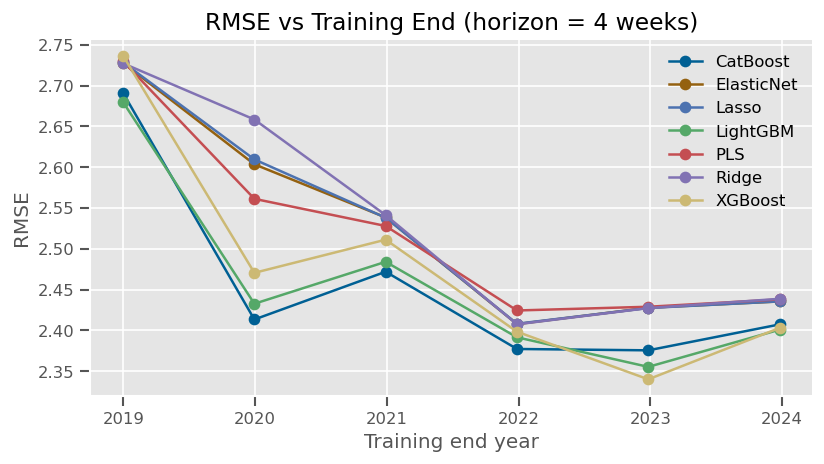

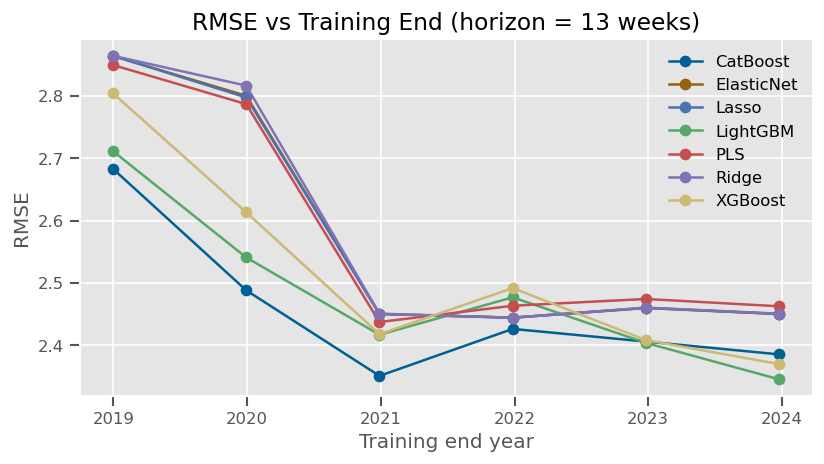

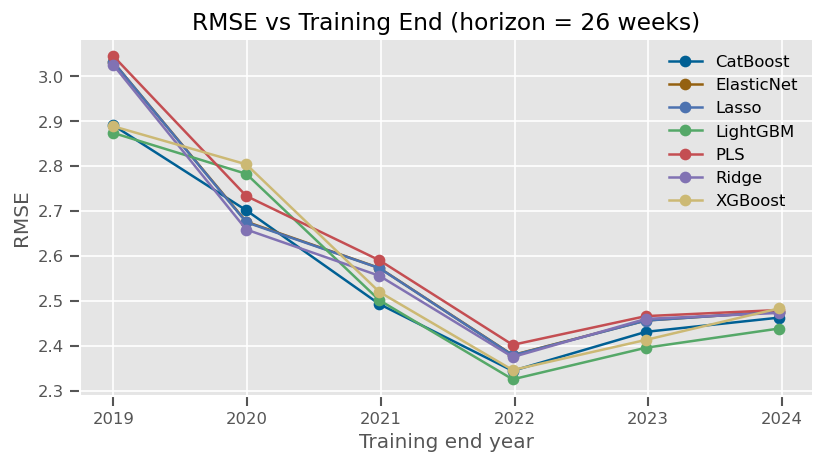

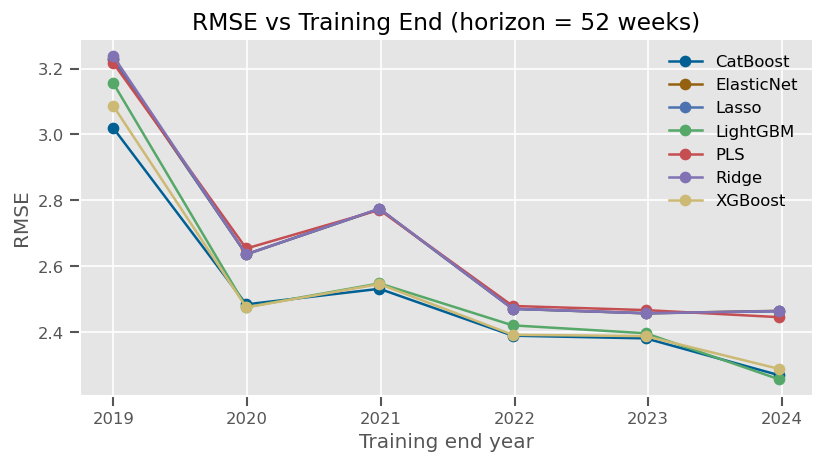

In [39]:
import matplotlib.pyplot as plt

horizons = sorted(metrics_df["horizon"].unique())

for h in horizons:
    df_h = metrics_df[metrics_df["horizon"] == h]

    plt.figure(figsize=(7, 4))
    for model in df_h["model"].unique():
        d = df_h[df_h["model"] == model]
        plt.plot(d["train_end"], d["rmse"], marker="o", label=model)

    plt.title(f"RMSE vs Training End (horizon = {h} weeks)")
    plt.xlabel("Training end year")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


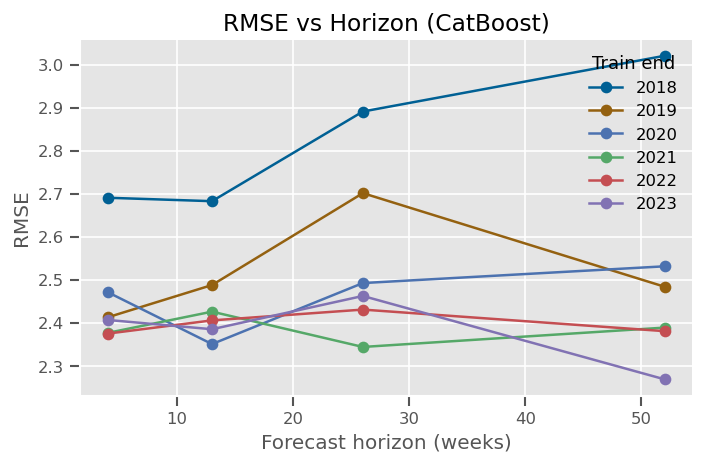

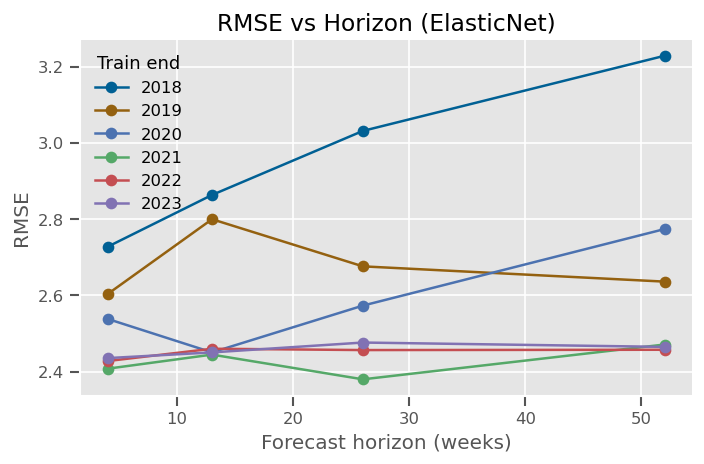

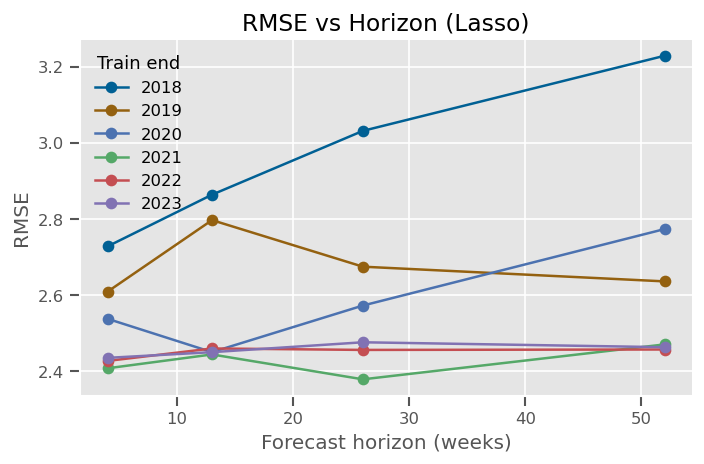

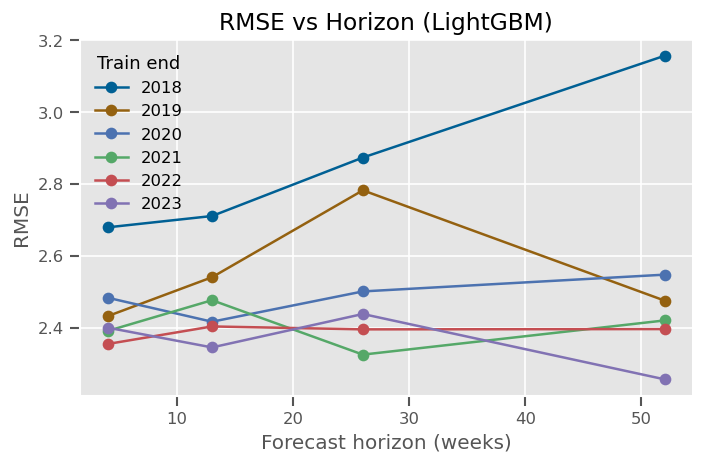

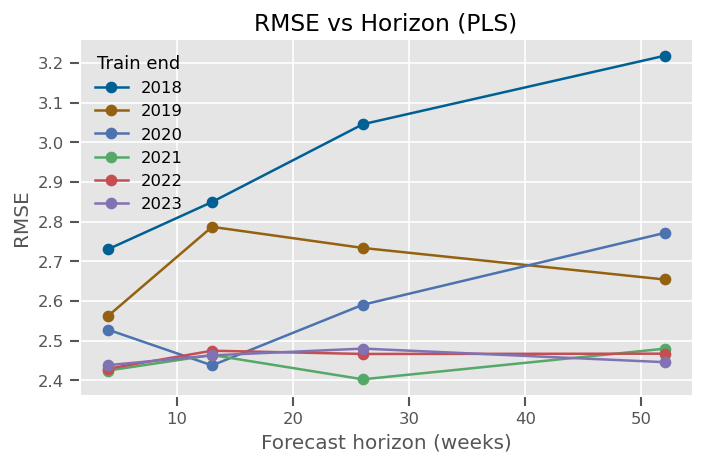

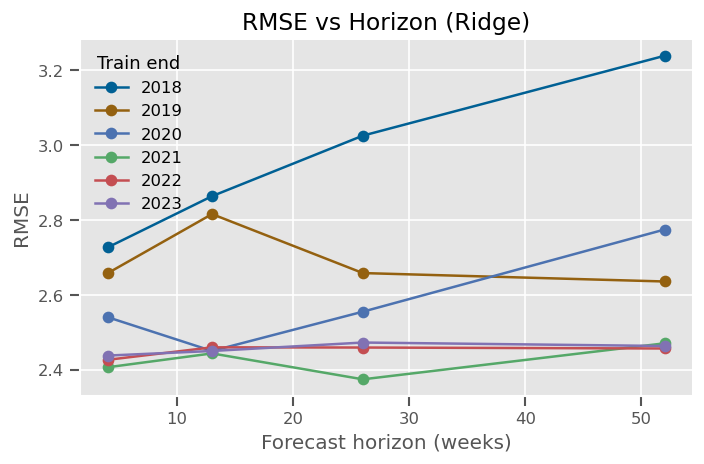

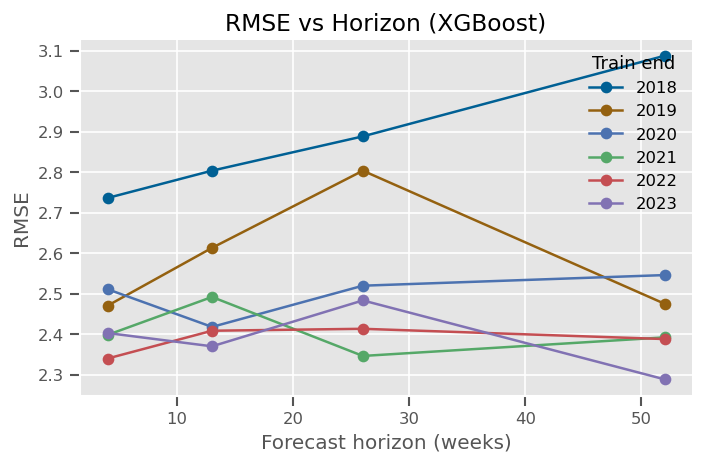

In [40]:
for model in metrics_df["model"].unique():
    d = metrics_df[metrics_df["model"] == model]

    plt.figure(figsize=(6, 4))
    for te in sorted(d["train_end"].unique()):
        dd = d[d["train_end"] == te]
        plt.plot(dd["horizon"], dd["rmse"], marker="o", label=str(te.year))

    plt.title(f"RMSE vs Horizon ({model})")
    plt.xlabel("Forecast horizon (weeks)")
    plt.ylabel("RMSE")
    plt.legend(title="Train end")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


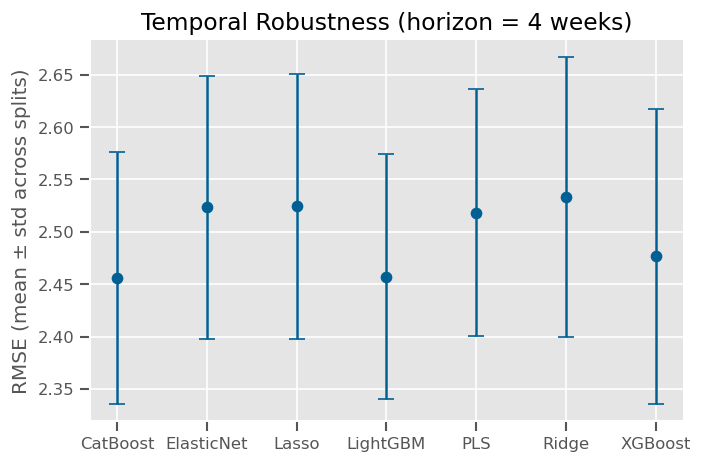

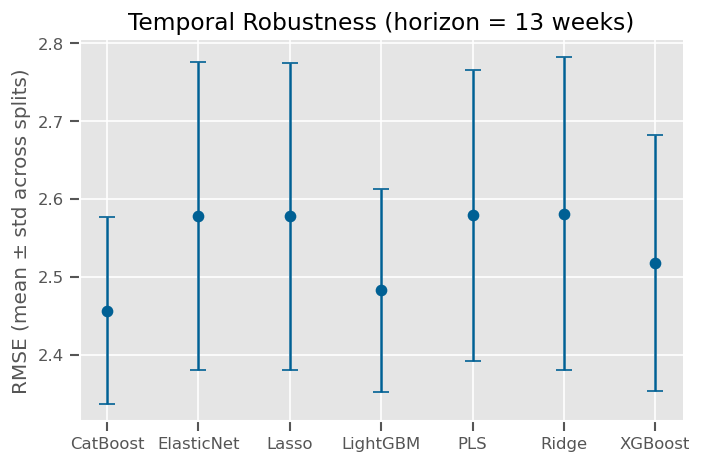

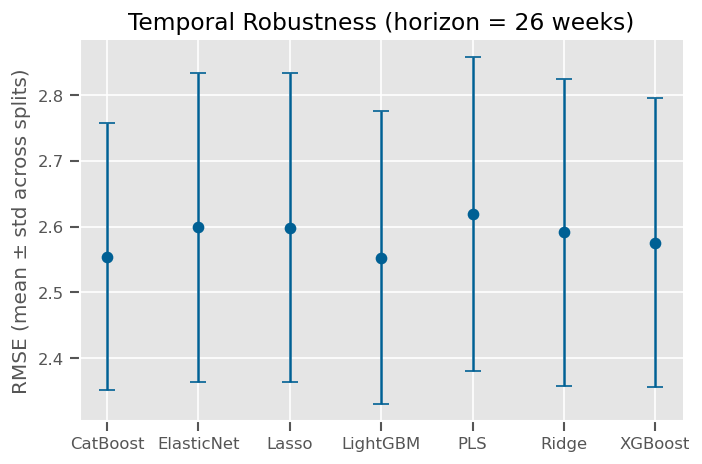

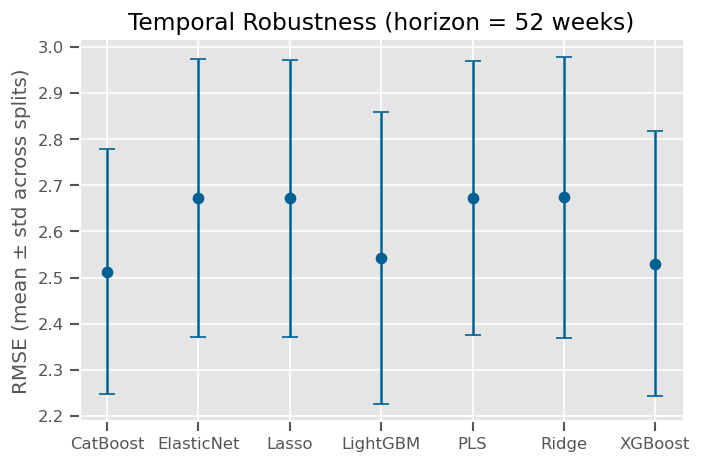

In [41]:
summary = (
    metrics_df
    .groupby(["model", "horizon"])
    .agg(
        rmse_mean=("rmse", "mean"),
        rmse_std=("rmse", "std"),
    )
    .reset_index()
)

for h in horizons:
    d = summary[summary["horizon"] == h]

    plt.figure(figsize=(6, 4))
    plt.errorbar(
        d["model"],
        d["rmse_mean"],
        yerr=d["rmse_std"],
        fmt="o",
        capsize=5
    )
    plt.title(f"Temporal Robustness (horizon = {h} weeks)")
    plt.ylabel("RMSE (mean ± std across splits)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


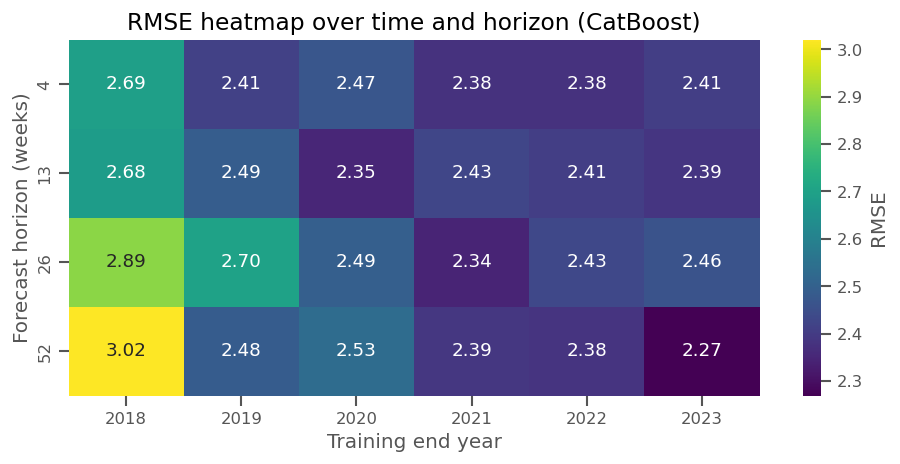

In [44]:
d = metrics_df[metrics_df["model"] == "CatBoost"].copy()
d["train_year"] = pd.to_datetime(d["train_end"]).dt.year

pivot = d.pivot(
    index="horizon",
    columns="train_year",
    values="rmse"
)


plt.figure(figsize=(8, 4))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "RMSE"}
)

plt.title("RMSE heatmap over time and horizon (CatBoost)")
plt.xlabel("Training end year")
plt.ylabel("Forecast horizon (weeks)")
plt.tight_layout()
plt.show()



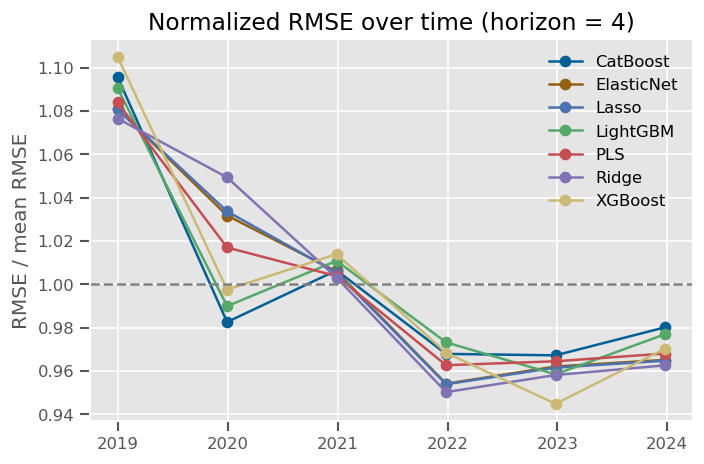

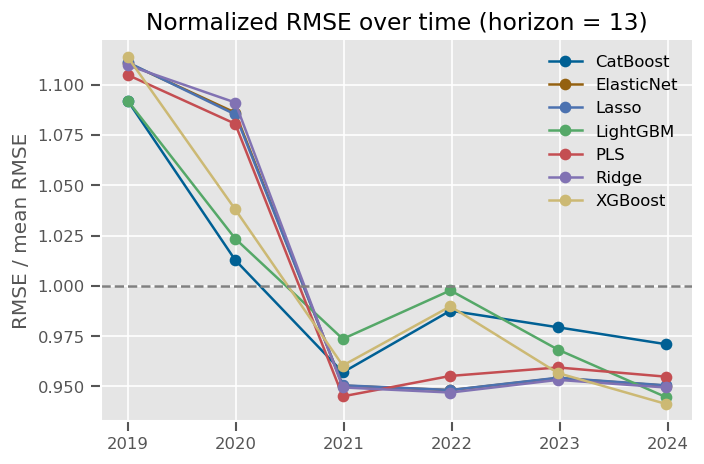

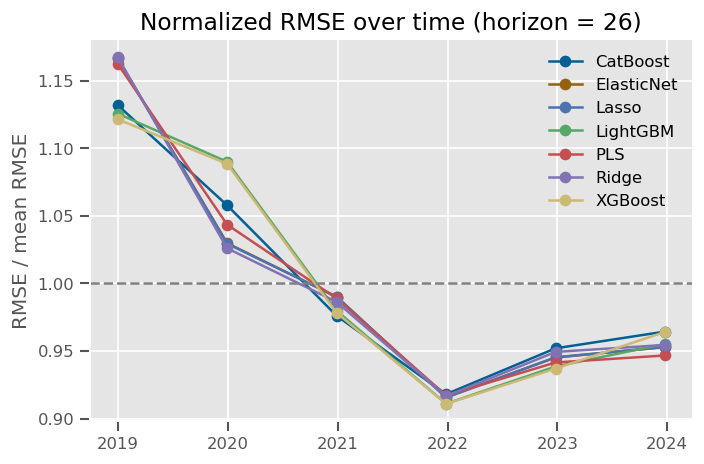

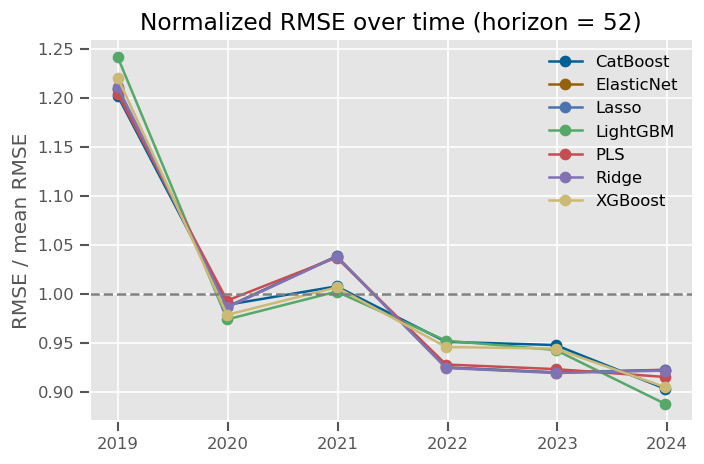

In [43]:
d = metrics_df.copy()

d["rmse_norm"] = (
    d["rmse"] /
    d.groupby(["model", "horizon"])["rmse"].transform("mean")
)

for h in sorted(d["horizon"].unique()):
    plt.figure(figsize=(6, 4))
    for model in d["model"].unique():
        dd = d[(d["horizon"] == h) & (d["model"] == model)]
        plt.plot(dd["train_end"], dd["rmse_norm"], marker="o", label=model)

    plt.axhline(1.0, color="gray", linestyle="--")
    plt.title(f"Normalized RMSE over time (horizon = {h})")
    plt.ylabel("RMSE / mean RMSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
